# CP421_2025W_Prj

## Setup

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
import joblib

C:\Users\dbob7\AppData\Local\Temp\ipykernel_23496\4091942172.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Load arXiv Scientific Research Papers Dataset

In [5]:
df = pd.read_csv(r'C:\Users\Adam\OneDrive\Desktop\CP421\arXiv_scientific_dataset.csv') # load dataset as a pandas dataframe object from local directory

# confirm dataset structure
print("Dataset Info:")
df.info()
print("\nFirst 5 Rows:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136238 entries, 0 to 136237
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   id                  136238 non-null  object
 1   title               136238 non-null  object
 2   category            136238 non-null  object
 3   category_code       136238 non-null  object
 4   published_date      136238 non-null  object
 5   updated_date        136238 non-null  object
 6   authors             136238 non-null  object
 7   first_author        136238 non-null  object
 8   summary             136238 non-null  object
 9   summary_word_count  136238 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 10.4+ MB

First 5 Rows:
             id                                              title  \
0  cs-9308101v1                               Dynamic Backtracking   
1  cs-9308102v1  A Market-Oriented Programming Environment and ...   
2  cs-93091

### Dataset Attributes
Let's first examine the data format of each attribute in the dataset:

- *id*: A unique identifier for each paper. E.g., cs-9308101v1

- *title*:
Title of the research paper. E.g., Dynamic Backtracking

- *category*:
The arXiv category which the paper is classified. E.g:., Artificial Intelligence

- *category_code*:
Code the category of the paper. E.g., cs.AI

- *published_date*:
Publication date of the research paper. E.g., 8/1/93

- *updated_date*
Last updated date when the paper is updated. E.g., 8/1/93

- *authors*
Authors of the research paper. E.g., ['M. L. Ginsberg']

- *first_author*:
First Author mentioned in the paper. E.g., 'M. L. Ginsberg'

- *summary*:
Summary of the research paper. E.g., Because of their occasional need to return to shallow points in a search tree, existing backtracking...

- *summary_word_count*:
Word count of the summary. E.g., 79


## Investigate Dataset

In [8]:
print(f"\nNumber of Rows: {df.shape[0]}")
print(f"Number of Columns: {df.shape[1]}")

print("\nSummary Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isna().sum())

print("\nColumn Data Types:")
print(df.dtypes)

print("\nNumber of Duplicates:")
print(df.duplicated().sum())

# distribution of categories
print("\nCategory Distribution:")
print(df['category'].value_counts())

# check the first 20 unique values for the "category" column
print("\nFirst 20 Unique Values in 'category_code':")
print(df['category_code'].unique()[:20])

# check the date ranges
df['published_date'] = pd.to_datetime(df['published_date'], format='%m/%d/%y', errors='coerce')
df['updated_date'] = pd.to_datetime(df['updated_date'], format='%m/%d/%y', errors='coerce')
print("\nDate Range (Published):", df['published_date'].min(), "to", df['published_date'].max())
print("Date Range (Updated):", df['updated_date'].min(), "to", df['updated_date'].max())


Number of Rows: 136238
Number of Columns: 10

Summary Statistics:
       summary_word_count
count       136238.000000
mean           162.386830
std             49.374474
min              1.000000
25%            128.000000
50%            160.000000
75%            195.000000
max            552.000000

Missing Values:
id                    0
title                 0
category              0
category_code         0
published_date        0
updated_date          0
authors               0
first_author          0
summary               0
summary_word_count    0
dtype: int64

Column Data Types:
id                    object
title                 object
category              object
category_code         object
published_date        object
updated_date          object
authors               object
first_author          object
summary               object
summary_word_count     int64
dtype: object

Number of Duplicates:
0

Category Distribution:
category
Machine Learning                               

### Basic Feature Investigation

Top 10 Authors by Number of Papers: first_author
'Yang Liu'             59
'Benjamin Doerr'       57
'Yang Li'              52
'Joseph Y. Halpern'    42
'Xi Chen'              41
'Hao Wang'             41
'Xiang Li'             38
'Wei Chen'             34
'Rui Wang'             33
'Jiawei Zhang'         32
Name: count, dtype: int64


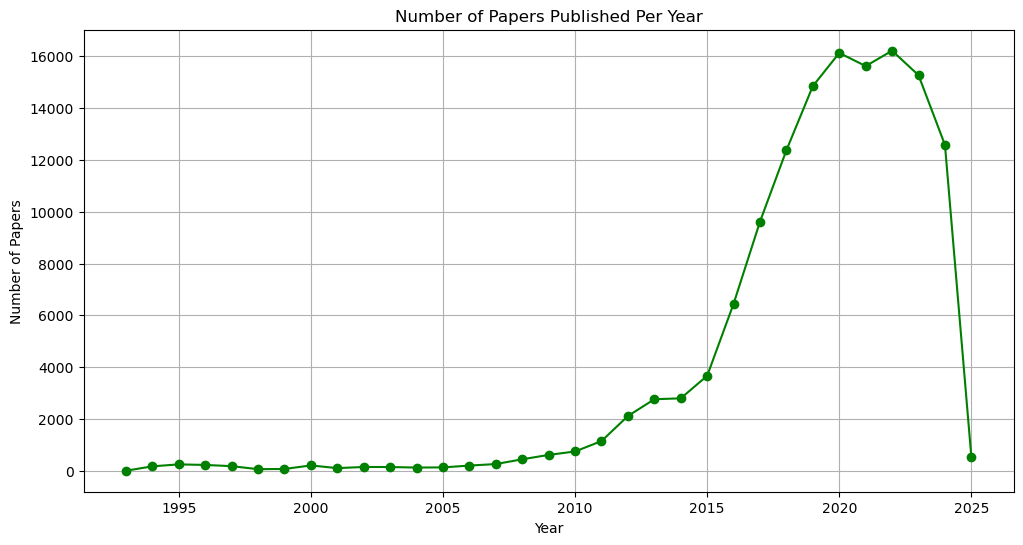


Top 10 Categories:
category
Machine Learning                                          39986
Computer Vision and Pattern Recognition                   29057
Computation and Language (Natural Language Processing)    25202
Artificial Intelligence                                   12969
Machine Learning (Statistics)                             10447
Neural and Evolutionary Computing                          5509
Robotics                                                    903
Information Retrieval                                       901
Methodology (Statistics)                                    882
Computation and Language (Legacy category)                  750
Name: count, dtype: int64


In [10]:
# author analysis (considering first author)
author_counts = df['first_author'].value_counts().head(10)
print("Top 10 Authors by Number of Papers:", author_counts)

# publication trends by year
df['published_year'] = pd.to_datetime(df['published_date'], errors='coerce').dt.year
year_counts = df['published_year'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.plot(year_counts.index, year_counts.values, marker='o', linestyle='-', color='green')
plt.title("Number of Papers Published Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Papers")
plt.grid(True)
plt.show()

# most common categories
category_counts = df['category'].value_counts().head(10)
print("\nTop 10 Categories:")
print(category_counts)

## Preprocess the Text: Focus on "Summary" Column
Before pre-processing any data, we must ensure that any preprocessing doesn't change the data integrity of the dataset. For example, a dot '.', is a stop word in the summary column but an essential identifier in the category_code column, eg: 'cs.AI'.

Based on the dataset structure and attributes, preprocessing will focus on the summary column since it contains the actual text data. The other columns (id, title, category, dates, authors, etc.), contain only 'marker data' and should remain untouched to preserve data integrity.

Therefore, the following must be applied to every data entry under the "summary" column: 
- **Stopword Removal**: Remove common stopwords (e.g., "the," "is," "of"), along with new stopwords customized to research papers (e.g., approach, paper) to focus on meaningful words that emphasize the concept over grammar.
- **Lowercasing**: Having multiple types of casing is not relevant to topic modelling and can cause same topics to be counted as different.
- **Removal of Non-Alphabet Characters**: Similar to lowercasing, numbers and punctuation are irrelevant to topic modelling and can make the data to be processed, longer than it needs to be.
- **Tokenization**: Break down the remaining words into individual words or tokens, for applying TF-IDF and making the feature vectors from.
- **Lematization**: Reduce words to a shorter dictionary format for easier processing.

In [12]:
# clean and lemmatize text
lemmatizer = WordNetLemmatizer()
default_stopwords = set(stopwords.words('english'))
additional_stopwords = {"et", "al", "using", "based", "also", "new", "approach", "paper", "method"}
stop_words = default_stopwords.union(additional_stopwords) # stopword set customized for research papers

# text preprocessing function
def preprocess_text(text):
    text = text.lower() # lowercase
    text = re.sub(r'[^a-zA-Z\s]', ' ', text) # remove non-alphabetic characters (punctuation, numbers, etc.)
    tokens = word_tokenize(text) # tokenization
    tokens = [word for word in tokens if word not in stop_words] # remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens] # lemmatization
    return ' '.join(tokens) # return processed text as a single string

df['processed_text'] = df['summary'].fillna('').apply(preprocess_text) # create new column 'processed_text' to work on
print("Preprocessed Dataset:")
print(df[['id', 'processed_text']].head()) # print the preprocessed dataset

# keyword frequency analysis from summary
summary_text = ' '.join(df['processed_text'])
keywords = summary_text.split()
keyword_counts = Counter(keywords) # count keyword frequencies
print()
print("Top 10 Keywords:", keyword_counts.most_common(10))

Preprocessed Dataset:
             id                                     processed_text
0  cs-9308101v1  occasional need return shallow point search tr...
1  cs-9308102v1  market price system constitute well understood...
2  cs-9309101v1  describe extensive study search gsat approxima...
3  cs-9311101v1  real logic programmer normally use cut effecti...
4  cs-9311102v1  support goal allowing user record retrieve inf...

Top 10 Keywords: [('model', 206226), ('learning', 122585), ('data', 120272), ('network', 98351), ('task', 81992), ('algorithm', 76972), ('problem', 71555), ('performance', 68953), ('result', 66577), ('method', 65311)]


Based on the results shown above, the tokenization, stopword removal, and lemmitization processes have been successfully implemented and are functioning as intended.

# Use Case 1: Topic Modelling and Dimensionality Reduction

In the first part of the notebook, we are going to perform topic modeling and dimensionality reduction on the arXiv dataset. We will pre-process the text data from the dataset (mainly from the summary attribute), create feature vectors from the preprocessed data using TF-IDF, use LDA to extract topics, and finally interpret the extracted topics based on the top words returned by the LDA.

This process will give us:
- Preprocessed dataset and feature vectors (TF-IDF or BERT).  
- LDA topics with top words and their interpretations.  
- Visualizations of topic distributions.

#### Use TF-IDF to Create Feature Vectors:
BERT takes into account the semantic meaning or context of the words which improves the LDA interpretation of the topics. However, it is resource-intensive and would require a GPU to compute which we don't have. 

Hence we will be using TF-IDF instead to create the feature vectors:

In [16]:
vectorizer = TfidfVectorizer(max_features=1000)  # limit vocabulary to 1000 most important words
X = vectorizer.fit_transform(df['processed_text'])

# print the feature vectors
print("TF-IDF Feature Vectors:") 
print(X.toarray()[:5])
vectorizer.get_feature_names_out()[:20] # inspect a subset of the extracted words

TF-IDF Feature Vectors:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.10406988 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


array(['ability', 'able', 'access', 'according', 'account', 'accuracy',
       'accurate', 'accurately', 'achieve', 'achieved', 'achieves',
       'achieving', 'across', 'action', 'activation', 'active',
       'activity', 'adapt', 'adaptation', 'adaptive'], dtype=object)

#### Use Latent Dirichlet Allocation (LDA) to Extract Topics:

In [18]:
num_topics = 5  # define the number of topics to extract
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

LatentDirichletAllocation(n_components=5, random_state=42)

In [19]:
# display the top words for each topic
def display_topics(model, feature_names, num_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        topics[f"Topic {topic_idx}"] = words
    return topics

feature_names = vectorizer.get_feature_names_out()
topics = display_topics(lda, feature_names, 10)

# print LDA topics with interpretations
print("LDA Topics and Top Words:")
for topic, words in topics.items():
    print(f"{topic}: {', '.join(words)}")

LDA Topics and Top Words:
Topic 0: network, data, graph, learning, model, neural, training, feature, classification, performance
Topic 1: language, model, text, task, word, llm, sentence, translation, knowledge, question
Topic 2: agent, system, learning, model, data, algorithm, ai, problem, user, decision
Topic 3: algorithm, function, problem, model, learning, distribution, bound, data, optimization, gradient
Topic 4: image, object, feature, network, detection, video, segmentation, model, proposed, dataset


#### Visualization of Topic Distributions

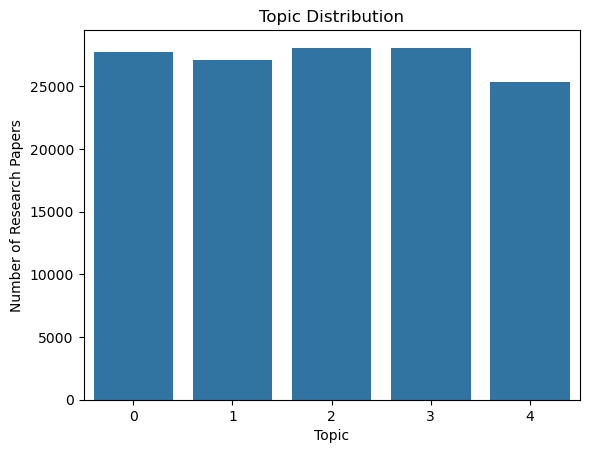

In [21]:
# visualize the topic distribution across documents
topic_distribution = lda.transform(X)
df['dominant_topic'] = topic_distribution.argmax(axis=1)

# create a plot for dominant topics
sns.countplot(x=df['dominant_topic'])
plt.xlabel("Topic")
plt.ylabel("Number of Research Papers")
plt.title("Topic Distribution")
plt.show()

# Use Case 2: Paper Category Classification
#### Model to predict a paper's category based on is title and summary

In [23]:
df['text'] = df['title'] + ' ' + df['summary'] # combine Title and Summary into new column 'text'
df['processed_text_combined'] = (df['text']).apply(preprocess_text) # preprocess combined title and summary into 'processed_text_combined'

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['processed_text']) # convert processed text into TF-IDF features with max 5000 features
y = df['category'] # set target variable for classification

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42) # split data into 85% train and 15% test

model = MultinomialNB()
model.fit(X_train, y_train) # initalize and train the Multinomial Naive Bayes Model

MultinomialNB()

#### Evaluate the model

In [25]:
y_pred = model.predict(X_test) # make predictions on test set
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred, zero_division = 0)) # print accuracy and classification

Accuracy: 0.7021922098257977
Classification Report:
                                                                   precision    recall  f1-score   support

                                             Accelerator Physics       0.00      0.00      0.00         1
                          Adaptation and Self-Organizing Systems       0.00      0.00      0.00         5
                                                Analysis of PDEs       0.00      0.00      0.00         2
                                       Applications (Statistics)       0.00      0.00      0.00        40
                                         Artificial Intelligence       0.63      0.57      0.60      1920
                                                    Astrophysics       0.00      0.00      0.00         2
                                 Atmospheric and Oceanic Physics       0.00      0.00      0.00         4
                                     Audio and Speech Processing       0.00      0.00      0.00   

In [26]:
# sample
sample_df = pd.DataFrame({'True Category': y_test, 'Predicted Category': y_pred}) # show true vs predicted categories
sample_df.head(10) # sample 10 rows for inspection

,True Category,Predicted Category
78358,Machine Learning (Statistics),Artificial Intelligence
37291,Machine Learning,Computer Vision and Pattern Recognition
132977,Computation and Language (Natural Language Pro...,Computation and Language (Natural Language Pro...
69011,Computer Vision and Pattern Recognition,Computer Vision and Pattern Recognition
57403,Computer Vision and Pattern Recognition,Computer Vision and Pattern Recognition
59143,Computer Vision and Pattern Recognition,Computer Vision and Pattern Recognition
83077,Machine Learning,Machine Learning
117818,Computation and Language (Natural Language Pro...,Computation and Language (Natural Language Pro...
21567,Artificial Intelligence,Machine Learning
63453,Computer Vision and Pattern Recognition,Computer Vision and Pattern Recognition


Based on the results in the table above, the classifier predicts correctly for 7/10 samples which aligns with our accuracy score of 0.7.

# Use Case 3: Trend Analysis
### Analyze Category and Word Popularity Over Time (Top 10)

In [29]:
df['published_date'] = pd.to_datetime(df['published_date'], format='%m/%d/%y') # convert published_date column to (month, date, year) format

# count occurrences of each category and select the top 10 categories
category_counts = df['category'].value_counts()
top_categories = category_counts.head(10).index
df_top_categories = df[df['category'].isin(top_categories)].copy() # create a copy

df_top_categories['year'] = df_top_categories['published_date'].dt.year # extract publication year into a new column 'year'
category_trends = df_top_categories.groupby(['year', 'category']).size().unstack().fillna(0) # group by 'year' and 'category' to count the number of papers

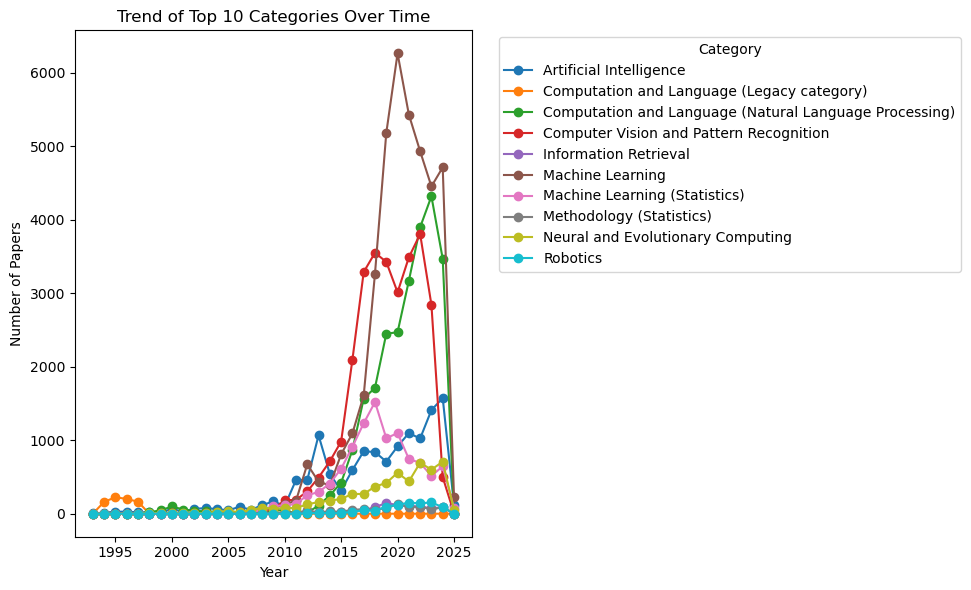

In [30]:
# plot the trend of top categories over time
category_trends.plot(kind='line', figsize=(10, 6), colormap='tab10', marker='o', linestyle='-', markersize=6)
plt.title('Trend of Top 10 Categories Over Time')
plt.ylabel('Number of Papers')
plt.xlabel('Year')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

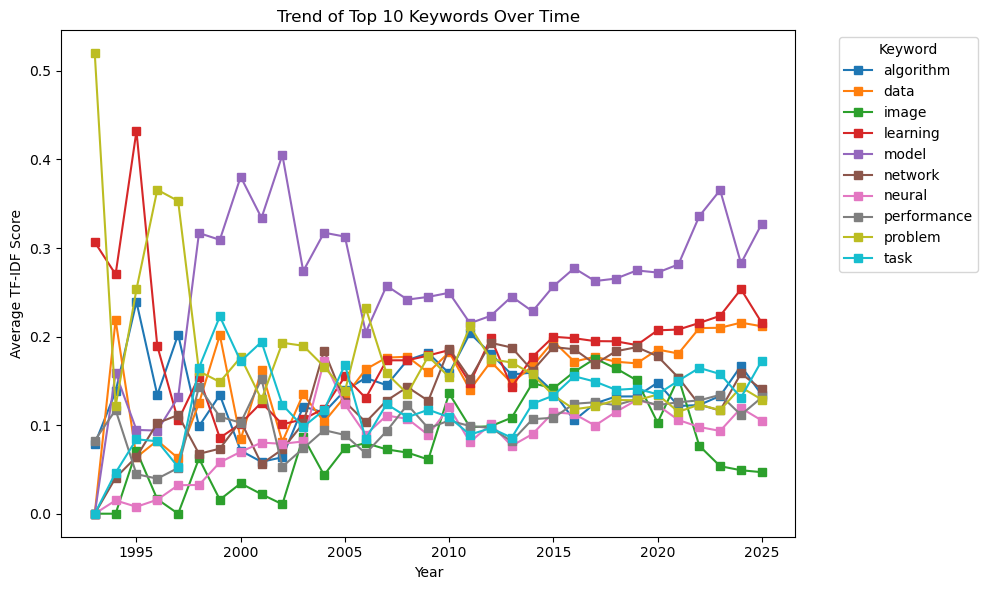

In [54]:
df_top_categories['processed_text'] = df_top_categories['text'].apply(preprocess_text) # preprocess text (title and summary) for filtered data

# use TF-IDF to extract the top 10 keywords from summaries
vectorizer = TfidfVectorizer(stop_words=None, max_features=10)
X = vectorizer.fit_transform(df_top_categories['processed_text'])

tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()) # create data frame from TF-IDF scores

# aggregate TF-IDF scores by year to see keyword trends
df_tfidf = df_top_categories[['year']].join(tfidf_df)
keyword_trends = df_tfidf.groupby('year').mean()

# plot keyword trends over time
keyword_trends.plot(kind='line', figsize=(10, 6), marker='s', linestyle='-', markersize=6)
plt.title('Trend of Top 10 Keywords Over Time')
plt.ylabel('Average TF-IDF Score')
plt.xlabel('Year')
plt.legend(title='Keyword', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Use Case 4: Recommendation Systems
#### Make recommendations based on topic similarity from LDA, content similarity from TF-IDF, and an approach which makes recommendations based on both content and topics.

In [33]:
def compute_similarity_batchwise(query_vector, topic_distributions, batch_size=1000):
    num_samples = topic_distributions.shape[0] # total number of samples
    similarity_scores = np.zeros(num_samples) # init similarity score array

    for i in range(0, num_samples, batch_size):
        batch = topic_distributions[i:i+batch_size] # extract batch
        batch_similarities = cosine_similarity(query_vector, batch).flatten() # compute cosine similarity
        similarity_scores[i:i+batch_size] = batch_similarities # store results

    return similarity_scores

# recommend similar papers based on LDA topic distributions
def get_similar_papers(paper_id, df, topic_distributions, top_n=5, batch_size=1000):
    paper_idx = df[df['id'] == paper_id].index[0]  # get the index of the sample paper
    query_vector = topic_distributions[paper_idx].reshape(1, -1) # reshape
    similarity_scores = compute_similarity_batchwise(query_vector, topic_distributions, batch_size=batch_size) # compute similarity scores
    similar_papers_idx = np.argsort(similarity_scores)[::-1][1:top_n+1]  # sort scores in descending order

    return df.iloc[similar_papers_idx][['id', 'title', 'category']] # return top n recommended papers

# select a paper for recommendations
paper_id = df['id'].iloc[0]
recommended_papers = get_similar_papers(paper_id, df, topic_distribution)
print("Paper:")
print(df.iloc[0][['id', 'title', 'category']])
print("\nRecommended Papers using LDA Topic Distribution:")
print(recommended_papers)

Paper:
id                     cs-9308101v1
title          Dynamic Backtracking
category    Artificial Intelligence
Name: 0, dtype: object

Recommended Papers using LDA Topic Distribution:
                     id                                              title  \
4954   abs-1604.05419v1  Extending the Harper Identity to Iterated Beli...   
28405  abs-2012.05862v1             Understanding Learned Reward Functions   
6          cs-9401101v1          Teleo-Reactive Programs for Agent Control   
4223   abs-1511.00787v1  A Pareto Optimal D* Search Algorithm for Multi...   
18376  abs-2210.04988v1      Simulating Coverage Path Planning with Roomba   

                      category  
4954   Artificial Intelligence  
28405         Machine Learning  
6      Artificial Intelligence  
4223   Artificial Intelligence  
18376                 Robotics  


In [34]:
# same function as def compute_similarity_batchwise but takes a tfidf_matrix instead of topic_disitrubtions
def compute_tfidf_similarity_batchwise(query_vector, tfidf_matrix, batch_size=1000):
    num_samples = tfidf_matrix.shape[0] # total number of samples
    similarity_scores = np.zeros(num_samples) # init similarity score array

    for i in range(0, num_samples, batch_size):
        batch = tfidf_matrix[i:i+batch_size] # extract batch
        batch_similarities = cosine_similarity(query_vector, batch).flatten() # compute cosine similarity
        similarity_scores[i:i+batch_size] = batch_similarities # store results

    return similarity_scores

# recommend similar papers using TF-IDF features
def get_similar_papers_tfidf(paper_id, df, tfidf_matrix, top_n=5, batch_size=1000):
    paper_idx = df[df['id'] == paper_id].index[0] # get the index of the sample paper
    query_vector = tfidf_matrix[paper_idx].reshape(1, -1) # reshape
    similarity_scores = compute_tfidf_similarity_batchwise(query_vector, tfidf_matrix, batch_size=batch_size)  # compute similarity scores
    similar_papers_idx = np.argsort(similarity_scores)[::-1][1:top_n+1]  # sort scores in descending order

    return df.iloc[similar_papers_idx][['id', 'title', 'category']] # return top n recommended papers

# select a paper for recommendations
paper_id = df['id'].iloc[0]
recommended_papers_tfidf = get_similar_papers_tfidf(paper_id, df, X)
print("Paper:")
print(df.iloc[0][['id', 'title', 'category']])
print("\nRecommended Papers using TF-IDF Feature Matrix:")
print(recommended_papers_tfidf)

Paper:
id                     cs-9308101v1
title          Dynamic Backtracking
category    Artificial Intelligence
Name: 0, dtype: object

Recommended Papers using TF-IDF Feature Matrix:
                      id                                              title  \
9481        cs-0208008v1             Soft Concurrent Constraint Programming   
1549     abs-1302.4930v1             Belief Functions and Default Reasoning   
9498        cs-0301007v1  Kalman filter control in the reinforcement lea...   
115205  abs-1806.00522v1  Improving Dialogue Act Classification for Spon...   
73158   abs-2302.13301v1   Pillar R-CNN for Point Cloud 3D Object Detection   

                                                 category  
9481                                Programming Languages  
1549                              Artificial Intelligence  
9498                                     Machine Learning  
115205  Computation and Language (Natural Language Pro...  
73158             Computer Vision and 